# NMS: Non-Maximum Suppression

In [4]:
import cv2
import numpy as np
import os
import json
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def load_yolo_annotations(annotation_file, image):
    bboxes = []
    with open(annotation_file, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.strip().split()
            # only extract x_center, y_center, width, height
            x_center, y_center, width, height = map(float, parts[1:5])
            # normalized axis to absolute pixel axis
            img_width, img_height = image.shape[1], image.shape[0]
            x_min = int((x_center - width / 2) * img_width)
            y_min = int((y_center - height / 2) * img_width)
            x_max = int((x_center + width / 2) * img_width)
            y_max = int((y_center + height / 2) * img_width)
            bboxes.append([x_min, y_min, x_max, y_max])
    return bboxes

def read_json(json_file):
    with open(json_file, 'r') as file:
        return json.load(file)
    
def extract_patches(image, bboxes):
    patches = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        patch = image[y_min:y_max, x_min:x_max]
        patch = Image.fromarray(patch)
        patches.append(patch)
    return patches


In [17]:
#! image with overlapping knot
target_image = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Bias/kNN_search/test_knn/warped_M5_0064.jpeg'
target_json = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Bias/kNN_search/test_knn/detected_warped_M5_0064.json'

# #! image with 6 knots
# target_image = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Bias/kNN_search/test_knn/warped_M1_0244.jpeg'
# target_json = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Bias/kNN_search/test_knn/detected_warped_M1_0244.json'

target_bboxes = []
target_score = []
   
# read image and json
image = cv2.imread(target_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
original_image = Image.fromarray(image)


json_data = read_json(target_json)

# extract bboxes
for box in json_data['boxes']:
    coordinates = (box['x1'], box['y1'], box['x2'], box['y2'])
    target_bboxes.append(coordinates)
    
    confidence = box['confidence']
    target_score.append(confidence)
    
print(target_bboxes)
print(target_score)


[(1355, 1513, 1716, 1996), (1291, 1447, 1725, 2155)]
[0.5232464671134949, 0.30010101199150085]


In [18]:
import torch

def non_max_suppression(boxes, scores, iou_threshold):
    if boxes.size(0) == 0:
        return torch.empty((0,), dtype=torch.int64)
    
    # Compute the area of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    # Sort the boxes by scores in descending order
    _, order = scores.sort(0, descending=True)

    keep = []
    while order.numel() > 0:
        # Select the box with the highest score and add its index to the keep list
        i = order[0]
        keep.append(i)

        if order.numel() == 1:
            break

        # Compute the IoU of the selected box with the rest
        xx1 = torch.max(x1[i], x1[order[1:]])
        yy1 = torch.max(y1[i], y1[order[1:]])
        xx2 = torch.min(x2[i], x2[order[1:]])
        yy2 = torch.min(y2[i], y2[order[1:]])

        w = torch.clamp(xx2 - xx1 + 1, min=0)
        h = torch.clamp(yy2 - yy1 + 1, min=0)
        inter = w * h
        iou = inter / (areas[i] + areas[order[1:]] - inter)

        # Keep boxes with IoU less than the threshold
        inds = torch.where(iou <= iou_threshold)[0]
        order = order[inds + 1]

    return torch.tensor(keep, dtype=torch.int64)

# to tensor
boxes = torch.tensor(target_bboxes, dtype=torch.float32)
scores = torch.tensor(target_score, dtype=torch.float32)
iou_threshold = 0.3

keep = non_max_suppression(boxes, scores, iou_threshold)
filtered_boxes = boxes[keep]
filtered_scores = scores[keep]

#! convert to list to original format
filtered_boxes_list = filtered_boxes.tolist()
filtered_scores_list = filtered_scores.tolist()

filtered_boxes_tuples = [tuple(int(coordinate) for coordinate in box) for box in filtered_boxes_list]

print(f"Kept boxes after NMS (as tuples): {filtered_boxes_tuples}")
print(f"Scores after NMS: {filtered_scores_list}")


Kept boxes after NMS (as tuples): [(1355, 1513, 1716, 1996)]
Scores after NMS: [0.5232464671134949]


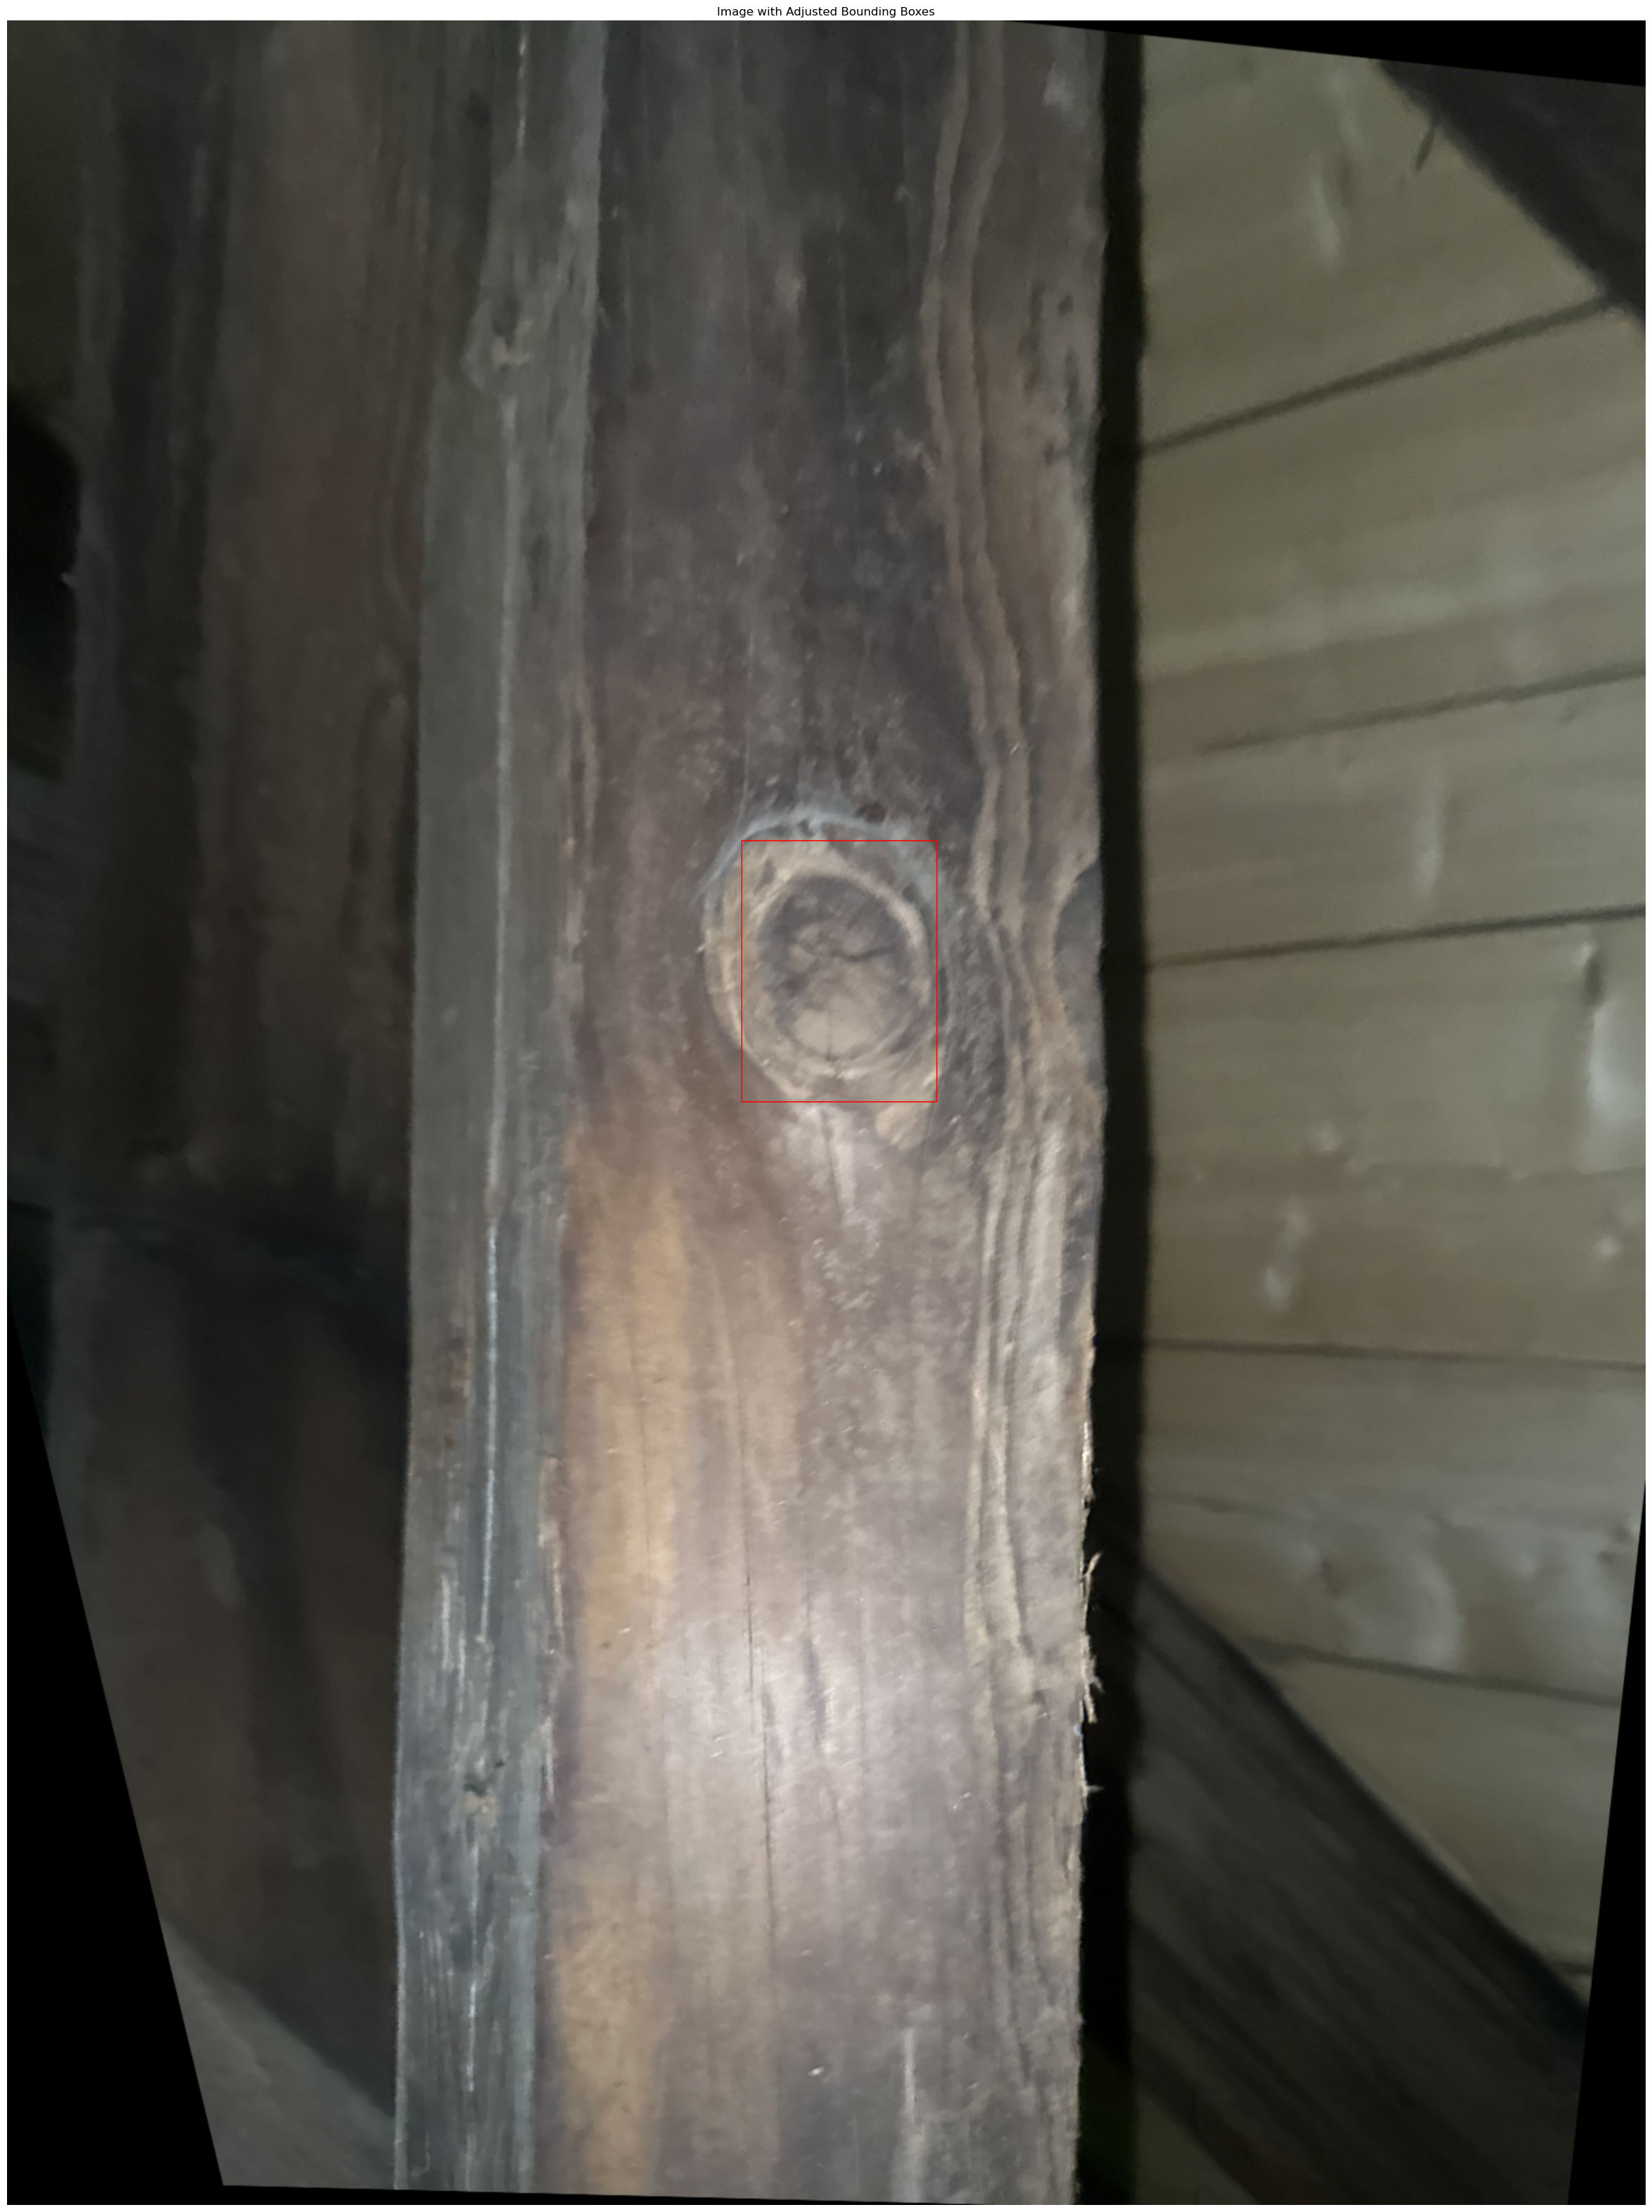

In [19]:
def draw_bboxes_on_image(original_image, bboxes):
    image_copy = original_image.copy()
    
    draw = ImageDraw.Draw(image_copy)

    for bbox in bboxes:
        draw.rectangle(bbox, outline="red", width=2)

    width, height = image_copy.size

    plt.figure(figsize=(width / 100, height / 100), dpi=100)
    
    plt.imshow(image_copy)
    plt.axis('off') 
    plt.title("Image with Adjusted Bounding Boxes")
    plt.show()

    return image_copy

result_image = draw_bboxes_on_image(original_image, filtered_boxes_tuples)
